In [27]:
import requests
import sqlite3
import time
from collections import defaultdict 
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

In [28]:
CITIES = ["Delhi", "Mumbai", "Chennai", "Bangalore", "Kolkata", "Hyderabad"]

# Setup the SQLite database
def setup_database():
    conn = sqlite3.connect('weather_monitoring1.db')
    cursor = conn.cursor()

    cursor.execute('''
    CREATE TABLE IF NOT EXISTS weather_data (
        id INTEGER PRIMARY KEY AUTOINCREMENT,
        city TEXT,
        main_weather TEXT,
        temperature REAL,
        feels_like REAL,
        humidity REAL,
        wind_speed REAL,
        timestamp INTEGER
    )''')

    cursor.execute('''
    CREATE TABLE IF NOT EXISTS daily_weather_summary (
        id INTEGER PRIMARY KEY AUTOINCREMENT,
        city TEXT,
        date TEXT,
        avg_temp REAL,
        avg_humidity REAL,
        avg_wind_speed REAL,
        max_temp REAL,
        min_temp REAL,
        dominant_weather TEXT
    )''')
    conn.commit()
    conn.close()

alert_thresholds = {
    'temp': 35,  # Alert if temperature exceeds 35°C
    'condition': 'Rain'  # Alert if condition is 'Rain'
}



consecutive_breaches = defaultdict(int)
weather_data_daily = defaultdict(list)

In [29]:
def fetch_weather_data(api_key, city):
    url = f"http://api.openweathermap.org/data/2.5/weather?q={city}&appid={api_key}"
    try:
        response = requests.get(url, timeout=10)
        if response.status_code == 200:
            return response.json()
        else:
            print(f"Failed to fetch data for {city}. Status code: {response.status_code}")
            return None
    except requests.exceptions.Timeout:
        print(f"Timeout occurred while fetching data for {city}")
        return None

In [30]:
# Function to convert Kelvin to Celsius
def kelvin_to_celsius(kelvin):
    return kelvin - 273.15


In [31]:
def store_weather_data(data, city):
    conn = sqlite3.connect('weather_monitoring1.db')
    cursor = conn.cursor()

    main_weather = data['weather'][0]['main']
    temp = kelvin_to_celsius(data['main']['temp'])
    feels_like = kelvin_to_celsius(data['main']['feels_like'])
    humidity = data['main'].get('humidity', None)  # Handle missing humidity
    wind_speed = data['wind'].get('speed', None)   # Handle missing wind_speed
    timestamp = data['dt']

    cursor.execute('''
    INSERT INTO weather_data (city, main_weather, temperature, feels_like, humidity, wind_speed, timestamp)
    VALUES (?, ?, ?, ?, ?, ?, ?)''', (city, main_weather, temp, feels_like, humidity, wind_speed, timestamp))

    conn.commit()
    conn.close()

In [32]:
def store_weather_data_for_rollup(data, city):
    temp = kelvin_to_celsius(data['main']['temp'])
    weather_condition = data['weather'][0]['main']
    timestamp = data['dt']

    # Extract humidity and wind_speed, ensure they're present
    humidity = data['main'].get('humidity', None)
    wind_speed = data['wind'].get('speed', None)

    weather_data_daily[city].append({
        'temp': temp,
        'condition': weather_condition,
        'humidity': humidity,  # Add humidity to rollup data
        'wind_speed': wind_speed,  # Add wind_speed to rollup data
        'timestamp': timestamp
    })

    check_alerts(city, temp, weather_condition)
    print(f"Added data for {city}: {weather_data_daily[city][-1]}")


In [33]:
def check_alerts(city, temp, condition):
    if temp > alert_thresholds['temp']:
        consecutive_breaches[city] += 1
        alert_message = f"Alert! Temperature for {city} exceeded {alert_thresholds['temp']}°C for {consecutive_breaches[city]} consecutive updates."
        print(alert_message)
        
        if consecutive_breaches[city] >= 2:
            print(f"Triggering alert for {city}: Temperature exceeded threshold for two consecutive updates.")
    else:
        consecutive_breaches[city] = 0

    if condition == alert_thresholds['condition']:
        alert_message = f"Alert! {city} is experiencing {condition}."
        print(alert_message)

In [34]:
def calculate_daily_aggregates(city):
    data = weather_data_daily[city]
    if not data:
        print(f"No data available for {city}")
        return None

    temps = [entry['temp'] for entry in data]

    # Safely access 'humidity' and 'wind_speed' with defaults if missing
    humidities = [entry.get('humidity', None) for entry in data if 'humidity' in entry]
    wind_speeds = [entry.get('wind_speed', None) for entry in data if 'wind_speed' in entry]

    avg_temp = sum(temps) / len(temps)

    avg_humidity = sum(humidities) / len(humidities) if humidities else None
    avg_wind_speed = sum(wind_speeds) / len(wind_speeds) if wind_speeds else None

    max_temp = max(temps)
    min_temp = min(temps)

    conditions = [entry['condition'] for entry in data]
    dominant_condition = max(set(conditions), key=conditions.count)

    return {
        'city': city,
        'date': str(datetime.date.today()),
        'avg_temp': avg_temp,
        'avg_humidity': avg_humidity,  # Will be None if data missing
        'avg_wind_speed': avg_wind_speed,  # Will be None if data missing
        'max_temp': max_temp,
        'min_temp': min_temp,
        'dominant_condition': dominant_condition
    }


In [35]:
def store_daily_summary_in_db(summary):
    conn = sqlite3.connect('weather_monitoring1.db')
    cursor = conn.cursor()

    cursor.execute('''
    INSERT INTO daily_weather_summary (city, date, avg_temp, avg_humidity, avg_wind_speed, max_temp, min_temp, dominant_weather)
    VALUES (?, ?, ?, ?, ?, ?, ?, ?)''', (
        summary['city'], summary['date'], summary['avg_temp'], 
        summary['avg_humidity'], summary['avg_wind_speed'], 
        summary['max_temp'], summary['min_temp'], summary['dominant_condition']
    ))

    conn.commit()
    conn.close()


In [36]:
def run_daily_rollup():
    print("Running daily rollup...")
    for city in CITIES:
        daily_summary = calculate_daily_aggregates(city)
        if daily_summary:
            print(f"Daily summary for {city}: {daily_summary}")
            store_daily_summary_in_db(daily_summary)
    weather_data_daily.clear()  # Clear the dictionary for the next day


In [37]:
def monitor_weather(api_key):
    setup_database()  # Ensure database is set up
    total_iterations = int(input("Enter how many iterations you want to run: "))
    iteration_count = 0
    
    while True:
        for city in CITIES:
            print(f"Fetching weather data for {city}...")
            weather_data = fetch_weather_data(api_key, city)
            if weather_data:
                store_weather_data(weather_data, city)
                store_weather_data_for_rollup(weather_data, city)
            else:
                print(f"No data fetched for {city}")
            time.sleep(2)

        run_daily_rollup()  # Trigger rollup after each round

        iteration_count += 1
        print(f"Iteration {iteration_count} completed.")

        # Check if the user wants to stop after the specified number of iterations
        if iteration_count >= total_iterations:
            user_input = input("Do you want to continue monitoring? (yes/no): ").strip().lower()
            if user_input == 'yes':
                additional_iterations = int(input("Enter the number of additional iterations: "))
                total_iterations += additional_iterations  # Add more iterations
            else:
                print("Stopping weather monitoring.")
                break

        time.sleep(30)

In [38]:
def visualize_weather_summary():
    conn = sqlite3.connect('weather_monitoring1.db')
    cursor = conn.cursor()

    query = "SELECT city, date, avg_temp, max_temp, min_temp FROM daily_weather_summary"
    cursor.execute(query)
    data = cursor.fetchall()
    
    conn.close()

    if not data:
        print("No data available for visualization.")
        return

    # Create a DataFrame-like structure for plotting
    cities, dates, avg_temps, max_temps, min_temps = zip(*data)

    # Plotting daily average temperature for each city
    plt.figure(figsize=(10, 6))
    sns.lineplot(x=dates, y=avg_temps, hue=cities, marker="o", legend="full")
    plt.title("Daily Average Temperature Across Cities")
    plt.xlabel("Date")
    plt.ylabel("Average Temperature (°C)")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [39]:
setup_database()
monitor_weather("31fbfb3277711daa2e0ae747d9eaee29")

Fetching weather data for Delhi...
Added data for Delhi: {'temp': 24.05000000000001, 'condition': 'Haze', 'humidity': 57, 'wind_speed': 0, 'timestamp': 1729873756}
Fetching weather data for Mumbai...
Added data for Mumbai: {'temp': 29.99000000000001, 'condition': 'Haze', 'humidity': 58, 'wind_speed': 0, 'timestamp': 1729873323}
Fetching weather data for Chennai...
Added data for Chennai: {'temp': 29.420000000000016, 'condition': 'Mist', 'humidity': 85, 'wind_speed': 3.09, 'timestamp': 1729873662}
Fetching weather data for Bangalore...
Added data for Bangalore: {'temp': 22.600000000000023, 'condition': 'Mist', 'humidity': 81, 'wind_speed': 1.54, 'timestamp': 1729873412}
Fetching weather data for Kolkata...
Alert! Kolkata is experiencing Rain.
Added data for Kolkata: {'temp': 25.970000000000027, 'condition': 'Rain', 'humidity': 94, 'wind_speed': 2.06, 'timestamp': 1729873622}
Fetching weather data for Hyderabad...
Added data for Hyderabad: {'temp': 25.730000000000018, 'condition': 'Mist'

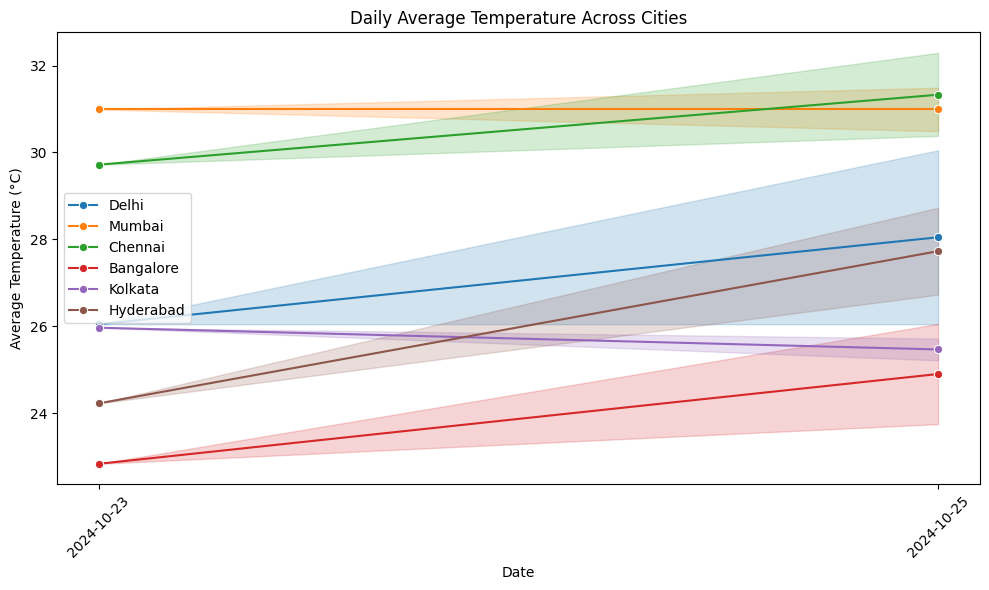

In [40]:
visualize_weather_summary()